# Libraries

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from numpy import array
import matplotlib.image as mpimg
import sys
import os
#from google.colab.patches import cv2_imshow
import glob 
from moviepy.editor import *
%matplotlib inline

# Camera Clibration

In [47]:
mtx = [] 
dist =[]
def calibration () :
    object_points = [] # real world corners 
    img_points =[] # corners get using open cv 
    images = glob.glob('./camera_cal/*.jpg')
    
    objp = np.zeros((9*6, 3), np.float32)  # 3d object real life points 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # to make it 2d [-1 in reshape to make it flexible ]

    for f in images:
        image = cv2.imread(f);
        # Convert to grayscale image
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find chessboard corners
        ret,corners = cv2.findChessboardCorners(gray , (9,6) , None )

        if ret:
            img_points.append(corners) #the corners 
            object_points.append(objp) # the expected right corners 

        shape = (image.shape[1], image.shape[0]) # size of image 
        global mtx 
        global dist 
        ret, mtx, dist, _, _ = cv2.calibrateCamera(object_points, img_points, shape, None, None)
        
    return mtx,dist 

def undistort(img): 
    return cv2.undistort(img, mtx, dist, None, mtx) 

# Show Outputs

In [48]:
# Plot function to compare two images [original vs. processed]
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Calibration Example

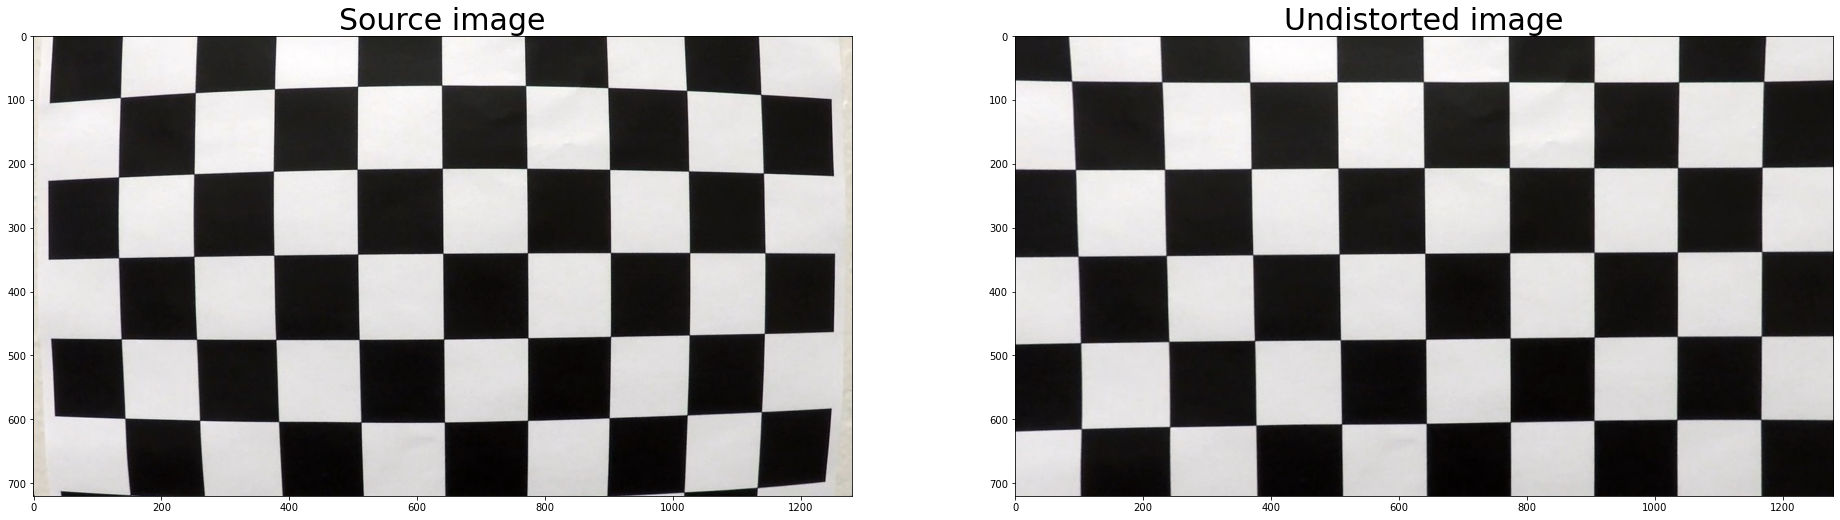

In [51]:
img = mpimg.imread('./camera_cal/calibration21.jpg')
calibration()
undistorted = undistort(img)   
plt_images(img, 'Source image', undistorted, 'Undistorted image')

# Perspective Transfrom

In [52]:
def Perspective_Transform(img):
    #detected_image = canny(img) ; #output of canny detection 
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [100,720]
    bottom_right = [1100, 720]
    top_left = [100, 0]
    top_right = [1100, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(source, dst) 
    # M is the matrix of perspective which mutliply with original and get the wrapped image
    M_inv = cv2.getPerspectiveTransform(dst, source)
    #print(img.shape)
    #img_size = (img.shape[1], img.shape[0]) 
    #warped = cv2.warpPerspective(detected_image, M, img_size , flags=cv2.INTER_LINEAR)
    return M , M_inv

# function to get top view from front view 
def forward_perspective(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    M , _  = Perspective_Transform(img)
    return cv2.warpPerspective(img,M, img_size, flags=flags) 

# function to get front view from top view 
def backward_perspective( img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    _ , M_inv  = Perspective_Transform(img)
    return cv2.warpPerspective(img, M_inv, img_size, flags=flags)

def detected_original(img) :
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]
    # Draw lines in image by these points by red color and its closed shape 
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    #print(pts,pts.shape)
    pts = pts.reshape((-1,1,2)) # to make each point as a list
    #print(pts,pts.shape)
    copy = img.copy()
    is_closed = True        
    cv2.polylines(copy,[pts],is_closed,(255,0,0), thickness=3)  
    return copy
    

# Perspective Example 

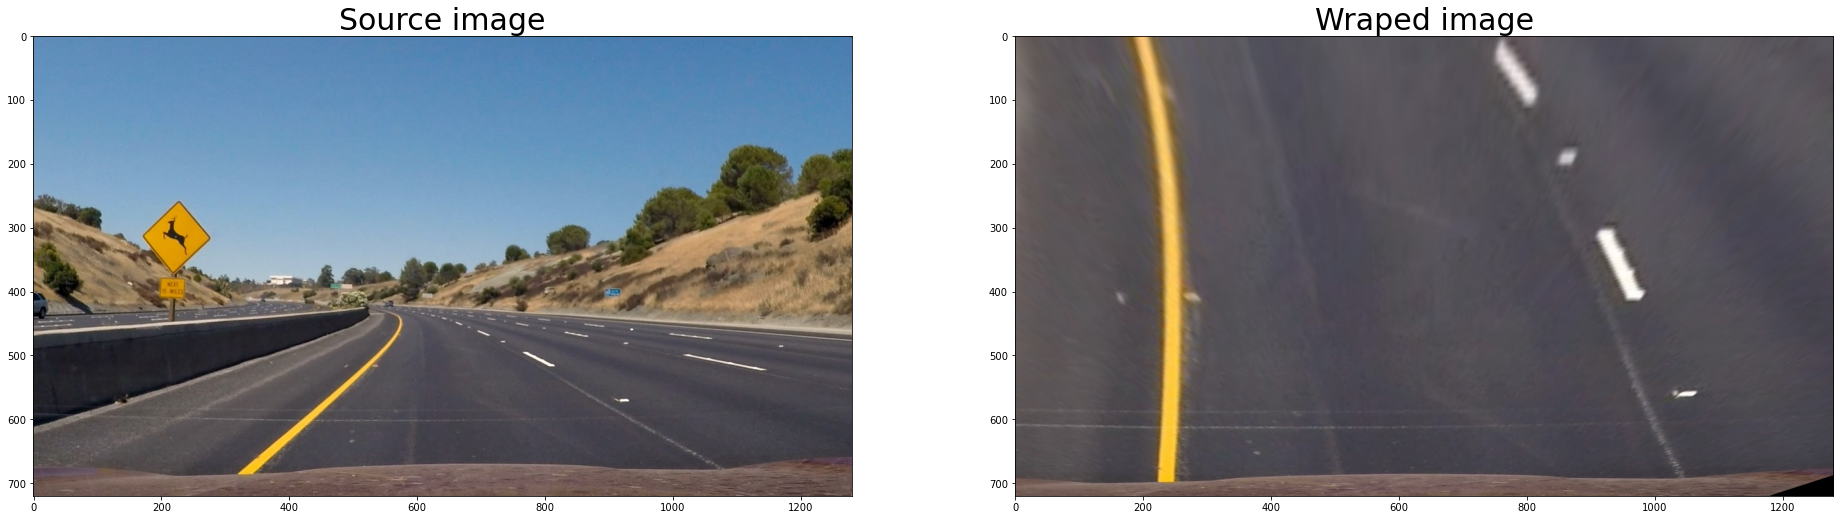

In [53]:
img = mpimg.imread('./test_images/test2.jpg')
wraped = forward_perspective(img)
plt_images(img, 'Source image', wraped, 'Wraped image')

# FitLines function

In [21]:
left_fit = []
right_fit = []

def pixels_in_window(nonzerox,nonzeroy, center, margin, height):
    topleft= (center[0]-margin, center[1]-height//2)
    bottomright= (center[0]+margin, center[1]+height//2)
    condx= (topleft[0] <= nonzerox) & (nonzerox<= bottomright[0])
    condy= (topleft[1] <= nonzeroy) & (nonzeroy<= bottomright[1])
    return nonzerox[condx&condy], nonzeroy[condx&condy]

def fitlines(warped):
#     left_fit = None
#     right_fit = None
    assert(len(warped.shape) ==2)
    histogram=np.sum(warped[warped.shape[0]//2:,:],axis=0)
    #plt.imshow(histogram)
    midpoint=np.int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    leftx=[]
    lefty=[]
    rightx=[]
    righty=[]
    out_img = np.dstack((warped, warped, warped))*255
    windowsnum=9
    window_height=int(warped.shape[0]/windowsnum)
    leftx_curr=leftx_base
    rightx_curr=rightx_base
    halfWindowWidth=100
    minpix = 50
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    y_current=warped.shape[0] + window_height//2
# print(nonzero)
# print(nonzerox)
#print(nonzeroy)
# print(warped)


    for window in range(windowsnum):
        
        y_current -= window_height
        center_left = (leftx_curr, y_current)
        center_right= (rightx_curr, y_current)
        
        winYlow=warped.shape[0]-(window+1)*window_height
        winYhigh=warped.shape[0]-window*window_height
        win_xleft_low=leftx_curr-halfWindowWidth
        win_xleft_high=leftx_curr+halfWindowWidth
        win_xright_low=rightx_curr-halfWindowWidth
        win_xright_high=rightx_curr+halfWindowWidth
        cv2.rectangle(out_img,(win_xleft_low,winYlow),(win_xleft_high,winYhigh),
          (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,winYlow),(win_xright_high,winYhigh),(0,255,0), 2) 
#         good_left_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
#         good_right_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         left_lane_inds.append(good_left_inds)
#         right_lane_inds.append(good_right_inds)
        good_left_x, good_left_y =pixels_in_window(nonzerox,nonzeroy,center_left, halfWindowWidth, window_height)
        good_right_x, good_right_y =pixels_in_window(nonzerox,nonzeroy,center_right,halfWindowWidth, window_height)
        
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)  
        rightx.extend(good_right_x)
        righty.extend(good_right_y)
        
        if len(good_left_x) > minpix:
              leftx_curr = int(np.mean(good_left_x))
        if len(good_right_x) > minpix:        
              rightx_curr = int(np.mean(good_right_x))

    # print(good_left_inds)
    # print(good_right_inds)
    # print( nonzeroy,winYlow,nonzeroy >= winYlow)

#     left_lane_inds = np.concatenate(left_lane_inds)
#     right_lane_inds = np.concatenate(right_lane_inds)
#     leftx = nonzerox[left_lane_inds]
 # lefty = nonzeroy[left_lane_inds] 
#     leftx.extend(nonzerox[left_lane_inds])
#     lefty.extend(nonzeroy[left_lane_inds])
#     rightx.extend(nonzerox[right_lane_inds])
#     righty.extend(nonzeroy[right_lane_inds])
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds] 

#     if len(leftx) == 0:
#         left_fit =[]
#     else:
#         left_fit = np.polyfit(lefty, leftx, 2)
  
#     if len(rightx) == 0:
#         right_fit =[]
#     else:
#         right_fit = np.polyfit(righty, rightx, 2)
#    print(len(lefty))
#    print(len(righty))
    
    if len(lefty) > 1500:
        global left_fit
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(righty) > 1500:
        global right_fit
        right_fit = np.polyfit(righty, rightx, 2)
    #print("left_fit",left_fit)
    
    out_img[lefty, leftx] = [255, 0, 0]   #newwwwww
    out_img[righty, rightx] = [0, 0, 255] #newwwwww
    
    maxy = warped.shape[0] - 1
    miny = warped.shape[0] // 3
    if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

    if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

    ploty = np.linspace(miny, maxy, warped.shape[0])
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    return out_img, lefty, leftx, righty, rightx, ploty,histogram


## Radius_of_curvature

In [22]:
def lane_curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters to obtain the real curves values
    # real object width / width in pixel
    # we assume that the lane is 3.7 * 30 m;
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 700 or 730
    
    y_eval = np.max(ploty) #the bottom point (height-1)(lowest point in picture)

    # Fit new polynomials to x,y in world space
    #make new polynomials with new values of x,y in meters

    new_lefty = [i * ym_per_pix for i in lefty]
    new_leftx = [i * xm_per_pix for i in leftx]
    new_righty = [i * ym_per_pix for i in righty]
    new_rightx = [i * xm_per_pix for i in rightx]

    left_fit_cr = np.polyfit(new_lefty, new_leftx, 2) #returns coeff of second order function from highest to lowest
    right_fit_cr = np.polyfit(new_righty, new_rightx, 2) #second order because it is a curve

    # Calculate the new radii of curvature in meters to represent them
    # R=(1+(x')**2)**1.5/abs(x'');
    # equation=ax**2+bx+c, a=_fit_cr[0],b=_fit_cr[1],c=_fit_cr[2]
    # x is the value of y_eval which satisfies the equation but in meters
    # x'=2ay+b
    # x''=2a

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #take the average of the 2 curves
    radius = round((float(left_curverad) + float(right_curverad))/2.,2)

    return radius

# Draw_Lane


In [23]:
def draw_lane(warped, ploty):

    warp_zero = np.zeros_like(warped).astype(np.uint8) #make a picture like "wrap" all zeroes with type 8 bit each 0:255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) # make it an array of 3 elements
    
    #get the output of the second order equation obtained from plotted points :ax**2+bx+c
    # a=left_fit[0],b=left_fit[1],c=left_fit[2]
    #to get the x coordinates for the ploty array

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the dark image with the array of points calculated in a prespective view
    cv2.fillPoly(color_warp, np.int_([pts]), (100,0, 100)) 

    
    return color_warp

## Calculating car postion relative to lane

In [24]:
def measure_car_position(binary_warped, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the left hand side of the center of the lane
    car_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    
    return car_pos,center_lanes_x_pos

# Adding text to video 

In [25]:
def adding_text(final_img, car_pos,radius):
     # Using CV2 putText to write text into images
    #(image,text,co-ordinates of bottom left,font type,scale,colour,thickness,linetype)
    #cv2.putText(final_img, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(final_img,'Radius of Curvature: '+str(radius)[:7]+' m',(40,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final_img,'Car center postion to lane: '+str(car_pos)[:7]+' m',(40,130), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    return final_img

# Draw_vertical_lines

In [26]:
def draw_vertical_lines(xposition,image):
  line1=cv2.line(image,(int(image.shape[1]/2),720),(int(image.shape[1]/2),650),(255,255,255),10) #center of pic
  line2=cv2.line(image,(int(xposition),720),(int(xposition),650),(0,0,255),10) #center of lane
  return image


## Outputting merged picture

In [27]:
# define a function for vertically 
# concatenating images of different
# widths 
def vconcat_resize(img_list, interpolation 
                   = cv2.INTER_CUBIC):
      # take minimum width
    w_min = min(img.shape[1] 
                for img in img_list)
      
    # resizing images
    im_list_resize = [cv2.resize(img,
                      (w_min, int(img.shape[0] * w_min / img.shape[1])),
                                 interpolation = interpolation)
                      for img in img_list]
    # return final image
    return cv2.vconcat(im_list_resize)
  
# define a function for horizontally 
# concatenating images of different
# heights 
def hconcat_resize(img_list, 
                   interpolation 
                   = cv2.INTER_CUBIC):
      # take minimum hights
    h_min = min(img.shape[0] 
                for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img,
                       (int(img.shape[1] * h_min / img.shape[0]),
                        h_min), interpolation
                                 = interpolation) 
                      for img in img_list]
      
    # return final image
    return cv2.hconcat(im_list_resize)
  
# define a function for concatenating
# images of different sizes in
# vertical and horizontal tiles
def concat_tile_resize(list_2d, 
                       interpolation = cv2.INTER_CUBIC):
      # function calling for every 
    # list of images
    img_list_v = [hconcat_resize(list_h, 
                                 interpolation = cv2.INTER_CUBIC) 
                  for list_h in list_2d]
      
    # return final image
    return vconcat_resize(img_list_v, interpolation=cv2.INTER_CUBIC)

## Processing images and thresholding

In [28]:
op_number=0

def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)

    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

def process_image(img):
    # step 1:returning image in plane view
    #print(op_number)
    
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img_binary) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #new binary image 
    out_binary_img = cv2.cvtColor(img_binary,cv2.COLOR_GRAY2BGR)
        
    if (op_number=='2'):
        return out_binary_img
    
    first_detection = detected_original(img) #newwwwwwwwwwww
    if (op_number=='1'):
        return first_detection
    un_distort = undistort(img) #newwwwwwwwwwww
   
    img1=forward_perspective(un_distort) #newwwwwwwwwwww
    
    # step 2: thresholding
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    vmin= np.min(s_channel)
    vmax= np.max(s_channel)
    
    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,:750] = 0
    
    left_lane = threshold_abs(h_channel, 20, 30)
    left_lane &= threshold_rel(v_channel, 0.7, 1.0)
    left_lane[:,550:] = 0
    img2 = left_lane | right_lane #returns warped binary images of the two lanes
    out_img2= cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    
    if(op_number=='4'):
        return out_img2
    #cv2.imshow("image2",img2)
    # step 3: detect lane edged and draw lane 
    slidding, lefty, leftx, righty, rightx, ploty,histogram = fitlines(img2)
    
    if(op_number=='3'):
        return slidding
    
    radius = lane_curvatures(lefty, leftx, righty, rightx, ploty) #radius of curvature calculation
    #radius=10
    car_pos,center_lanes_x_pos = measure_car_position(img2, left_fit, right_fit) #returns car pos
    img3=draw_lane(img2, ploty)
    
    if(op_number=='5'):
        return img3
    
    # step 4 : returning normal prespective black photo with drawn lane
    img4 = backward_perspective(img3)
    
    if(op_number=='6'):
        return img4
    
    out_img = cv2.addWeighted(img, 1, img4, 1, 0) 
    final_out_img = adding_text(out_img,car_pos,radius)
    output_img = draw_vertical_lines(center_lanes_x_pos,final_out_img)
    
    if(op_number=='7'):
        return final_out_img
    
    #height, width = 1080, 1920
    #FinalScreen = np.array((height,width),float)
    #FinalScreen=array[1081][1921]
    #FinalScreen[0:720,0:1280] = cv2.resize(output_img, (1280,720), interpolation=cv2.INTER_AREA)
    #FinalScreen[0:360,1280:1920] = cv2.resize(first_detection, (640,360), interpolation=cv2.INTER_AREA)
    #cv2.imshow("screen",FinalScreen)
    #FinalScreen[360:720,1280:1920] = cv2.resize(img_binary, (640,360), interpolation=cv2.INTER_AREA)
    #FinalScreen[720:1080,1280:1920] = cv2.resize(slidding, (640,360), interpolation=cv2.INTER_AREA)
    #FinalScreen[720:1080,0:640] = cv2.resize(img3, (640,360), interpolation=cv2.INTER_AREA)
    #FinalScreen[720:1080,640:1280] = cv2.resize(img4, (640,360), interpolation=cv2.INTER_AREA)
    
    
    #Merging pictures
    
    pic1= hconcat_resize([out_img2,img3]) #returns merged horizontal pictures
    pic2= vconcat_resize([first_detection,out_binary_img,slidding]) ##return merged vertival pictures ###change "img" to tharwat's pic####
    pic3=concat_tile_resize([[final_out_img],[out_img2,img3]]) #return final_out_img with other pictures underneath
    merged = hconcat_resize([pic3,pic2])
    
    if(op_number=='8'):
        return merged

# Binary Image Front & plan view

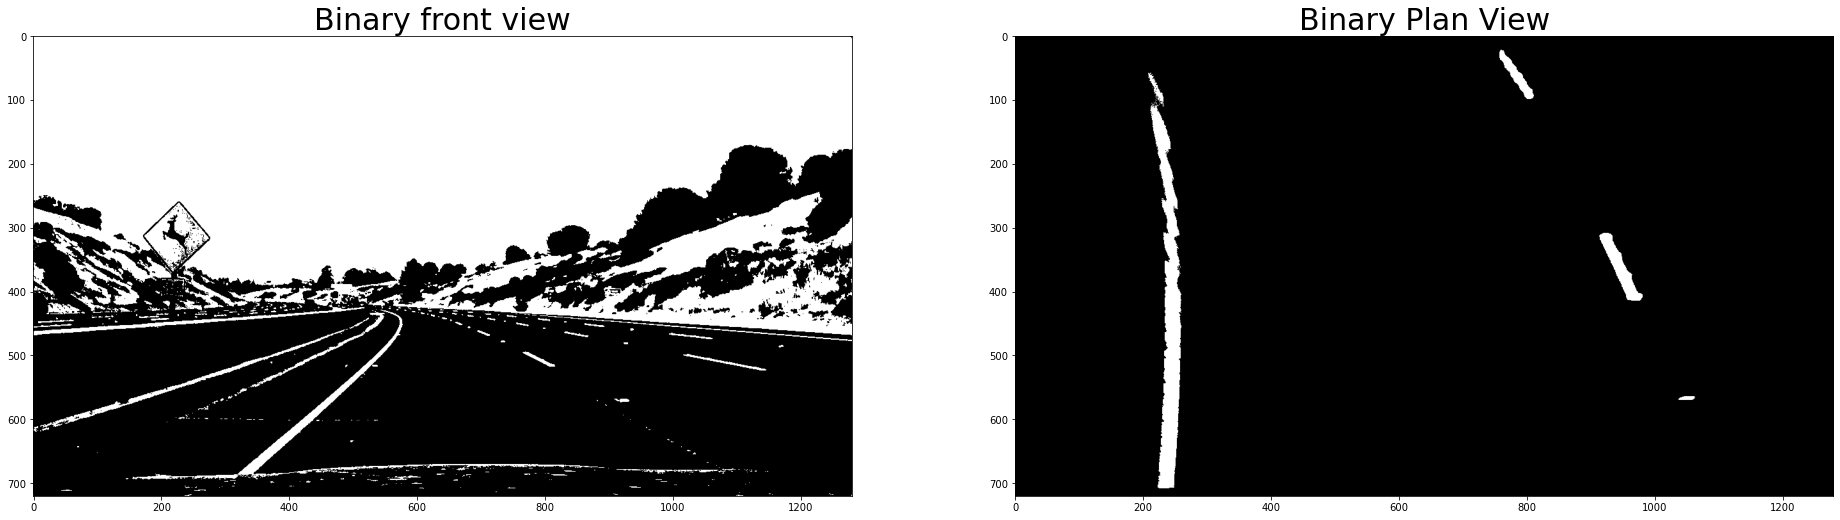

In [64]:
img = mpimg.imread('./test_images/test2.jpg')
op_number = '2'
binary_front = process_image(img) ###### Threasholding 
op_number = '4'
binary_plan = process_image(img) ###### Threasholding 

plt_images(binary_front, 'Binary front view', binary_plan, 'Binary Plan View')
op_number = 0

# Sliding Window Example

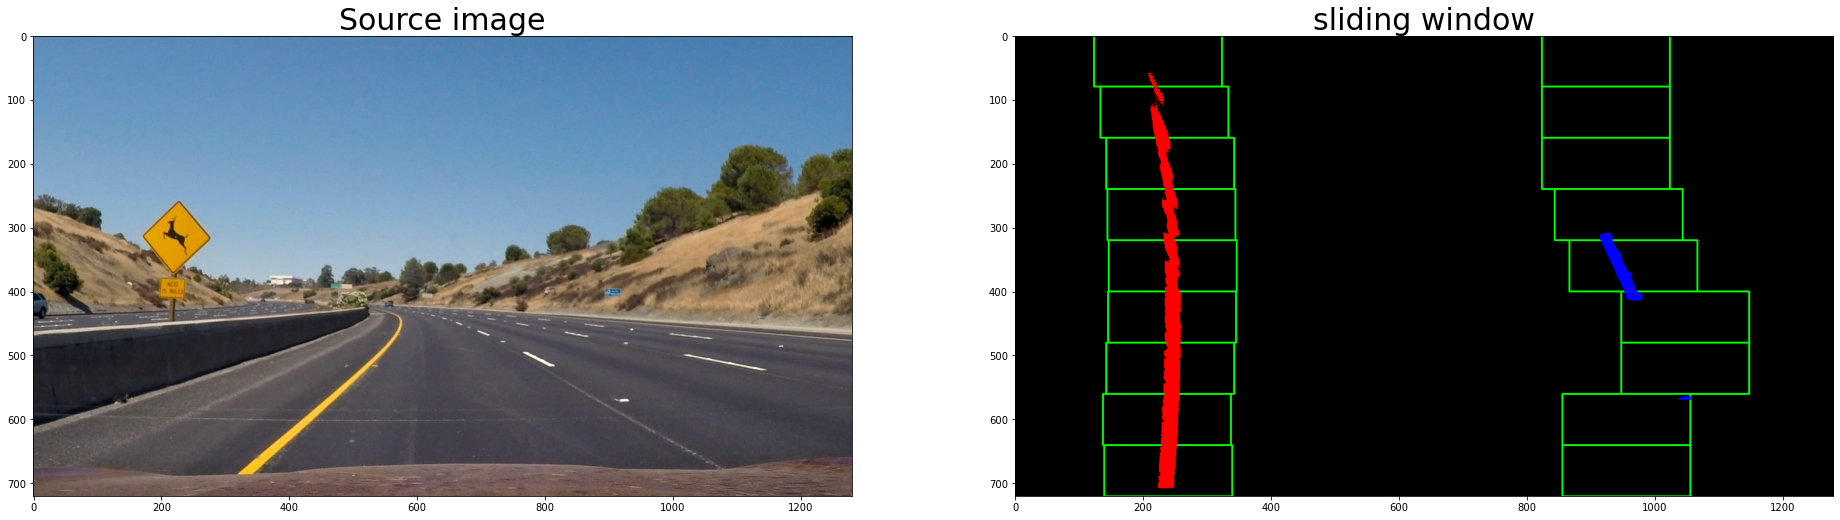

In [60]:
img = mpimg.imread('./test_images/test2.jpg')
op_number = '3'
sliding = process_image(img) ###### FitLine 
plt_images(img, 'Source image', sliding, 'sliding window')
op_number = 0

# Colored Lane Plane View

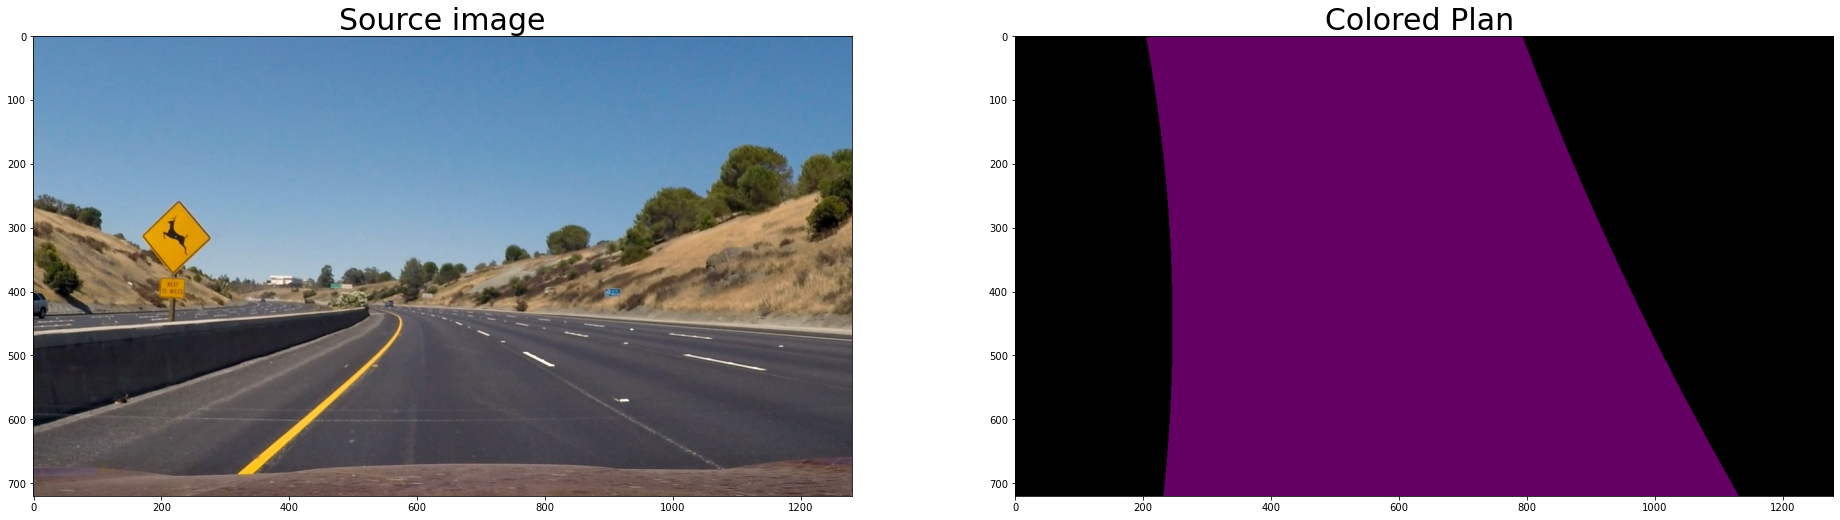

In [62]:
img = mpimg.imread('./test_images/test2.jpg')
op_number = '5'
Colored = process_image(img) #Draw Lane
plt_images(img, 'Source image', Colored , 'Colored Plan ')
op_number = 0

# Final Image 

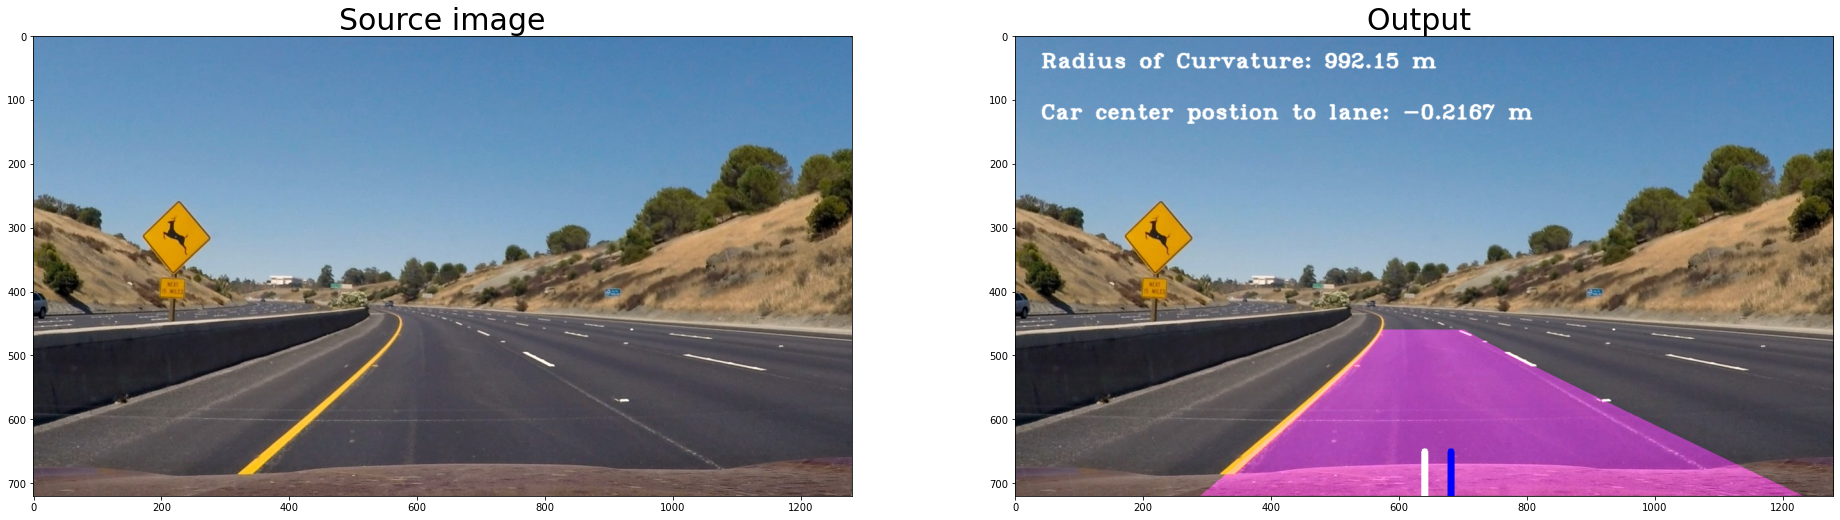

In [65]:
img = mpimg.imread('./test_images/test2.jpg')
op_number = '7'
Final = process_image(img) #Draw Lane
plt_images(img, 'Source image', Final , 'Output ')
op_number = 0

## Image

In [29]:
def take_image(path):
    image = mpimg.imread(path)
    #print(image.shape)
    plt.imshow(image)
    plt.show()
    tmp = process_image(image)
    #mpimg.imsave('output image.jpg',tmp)
    plt.imshow(tmp)
    plt.show()
    #cv2.destroyAllwindows()



# Save video

In [30]:
def process_video(path):
    clip = VideoFileClip(path)
    out_clip = clip.fl_image(process_image)
    out_clip.write_videofile("output.mp4",fps=clip.fps, audio=False)

## Main_Function

In [31]:
def main():
    
    print("WELCOME TO OUR LANE DETECTION PROGRAM")
    print("DO you want to input : 1-image 2-video")
    x=input("please enter 1 or 2: ")   
    path = input("Enter the path of your file: ") 
    calibration()
    assert os.path.exists(path), "I did not find the file at, "+str(path)
    while (1):
        print("what operation do you want to make on the input : ")
        print("1: edge fence") #first detection
        print("2: Binary image") #lesa
        print("3: sliding window algorithm") #sliding
        print("4: Binary plan view") #image2
        print("5: highlighted lane plane view") #image3
        print("6: highlighted lane plane") #image4
        print("7: the final output") #final output video
        print("8: debugging mode")
        global op_number
        op_number= input("choose the operation number: ")
        
        if (x == '1'): #image
            take_image(path)
        else: 
            process_video(path)
        print("you can now preview the saved output")    
        letter=input("Do you want to make another opertaion ? y/n")
        if (letter=='n'):
            break

WELCOME TO OUR LANE DETECTION PROGRAM
DO you want to input : 1-image 2-video
please enter 1 or 2: 1
Enter the path of your file: ./test_images/test2.jpg
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 1


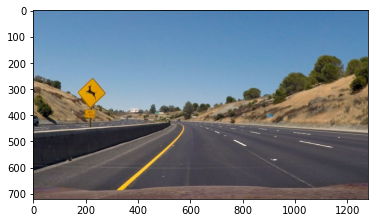

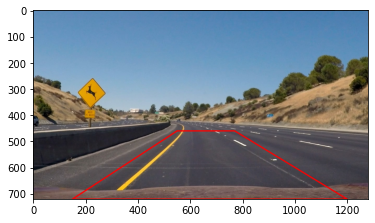

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 2


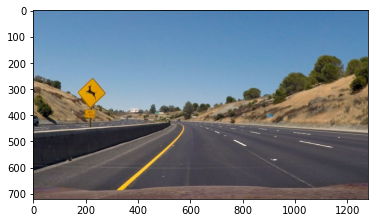

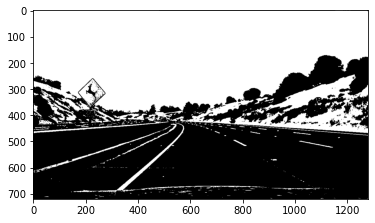

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 3


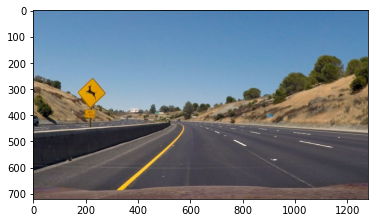

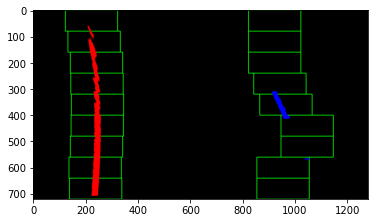

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 4


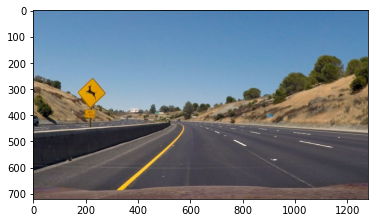

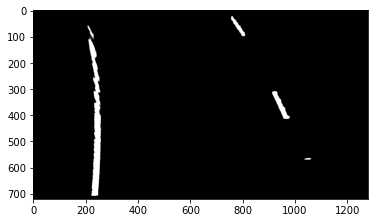

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 5


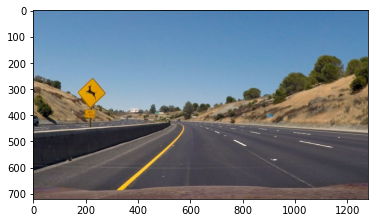

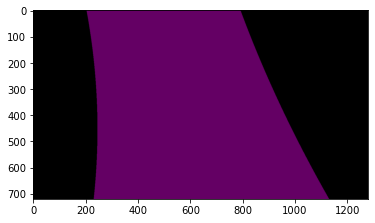

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 6


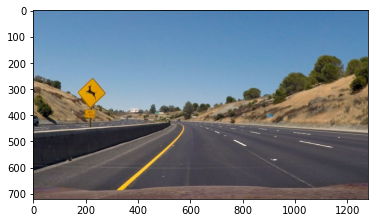

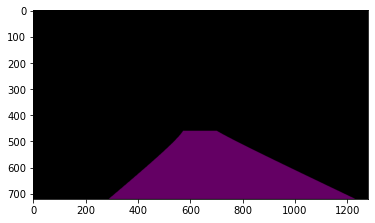

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 7


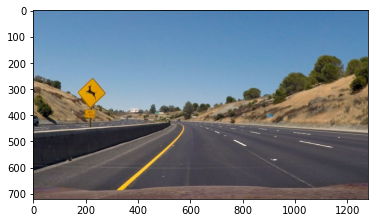

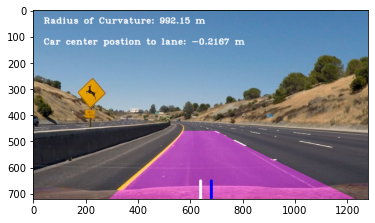

you can now preview the saved output
Do you want to make another opertaion ? y/ny
what operation do you want to make on the input : 
1: edge fence
2: Binary image
3: sliding window algorithm
4: Binary plan view
5: highlighted lane plane view
6: highlighted lane plane
7: the final output
8: debugging mode
choose the operation number: 8


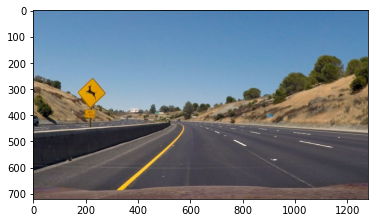

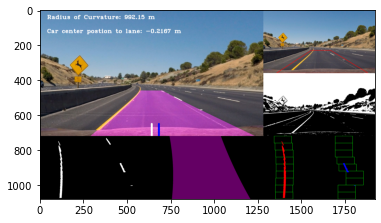

you can now preview the saved output
Do you want to make another opertaion ? y/nn


In [66]:
if __name__ == "__main__":
    main()